# Networking for Big Data - Project
- Jonas Barth 2050678
- Susanna Bravi 1916681
- Eric Rubia Aguilera 2049558

# Part A
#### 1. Extract general info from your trace using capinfos

In [1]:
!capinfos -A _00000_20190410070000.pcap

File name:           _00000_20190410070000.pcap
File type:           Wireshark/... - pcapng
File encapsulation:  Ethernet
File timestamp precision:  microseconds (6)
Packet size limit:   file hdr: (not set)
Packet size limit:   inferred: 34 bytes - 96 bytes (range)
Number of packets:   1000 k
File size:           98 MB
Data size:           1099 MB
Capture duration:    3,637099 seconds
First packet time:   2019-04-10 07:00:00,056001
Last packet time:    2019-04-10 07:00:03,693100
Data byte rate:      302 MBps
Data bit rate:       2419 Mbps
Average packet size: 1099,84 bytes
Average packet rate: 274 kpackets/s
SHA256:              0cd5fd34ddec92a3ea2072d102cc125c6a91bccc9f99e782dc9474f042f9b176
RIPEMD160:           b60314ed2d84263202ef3012d196be7820c0cea7
SHA1:                16bb7fe63a5a4a37e1d9b0cab842ab9af17655ac
Strict time order:   False
Capture application: Editcap (Wireshark) 3.4.2 (Git v3.4.2 packaged as 3.4.2-1~ubuntu16.04.0+wiresharkdevstable1)
Number of interfaces in file: 1
I

#### 2. Time Evaluation between Sequential and Parallel reading

#### 3. Extract the IP which generates the highest amount as sender traffic, evaluate the bit rate (0.1 sec) for the 6 IP addresses mostly used as endpoint


In [69]:
import pyshark
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy
import sys
import shutil
import os
import plotly.express as px
from plotly.subplots import make_subplots


In [4]:
# It takes about 2 minutes (or more) to import the pkl file
dataFrame = pd.read_feather("packets.feather")
len(dataFrame)

832768

In [5]:
dataFrame

Label DSCP  header len  ds_field ds_field_ecn  length  Protocol  \
0               0          20         0            0      95        17   
1               0          20         0            0    1420         6   
2               0          20         0            0      52         6   
3               0          20         0            0      52         6   
4               0          20         0            0     141        17   
...           ...         ...       ...          ...     ...       ...   
832763          0          20         0            0    1454         6   
832764          0          20         0            0    1500         6   
832765          0          20         0            0    1500         6   
832766          0          20         0            0    1500         6   
832767          0          20         0            0      40         6   

       flag_df flag_mf flag_rb fragment_offset  ttl           IP_SRC  \
0            1       0       0               0   57     23.53.35.140   
1            1       0       0               0   56   150.57.136.251   
2            0       0       0               0   54  180.213.208.201   
3            0       0       0               0   54  180.213.208.201   
4            0       0       0               0   58    150.57.190.76   
...        ...     ...     ...             ...  ...              ...   
832763       1       0       0               0   56   150.57.136.251   
832764       1       0       0               0   60   150.57.136.251   
832765       1       0       0               0   60   150.57.136.251   
832766       1       0       0               0   60   150.57.136.251   
832767       0       0       0               0  124   172.201.24.110   

                 IP_DST  src_port  dst_port          time  
0        131.137.126.25        53     48350  1.554872e+09  
1       221.244.225.179        80     64918  1.554872e+09  
2        203.122.136.47     53480        80  1.554872e+09  
3        203.122.136.47     53480        80  1.554872e+09  
4         155.70.48.196     50821     27023  1.554872e+09  
...                 ...       ...       ...           ...  
832763   222.127.201.52        80     62620  1.554872e+09  
832764     66.132.46.70       873      8878  1.554872e+09  
832765     66.132.46.70       873      8878  1.554872e+09  
832766     66.132.46.70       873      8878  1.554872e+09  
832767     131.137.54.7       443     52038  1.554872e+09  

[832768 rows x 16 columns]

In [6]:
#dataFrame.head()
source = dataFrame.groupby(["IP_SRC"])
len(source) #we have 4548 different sources
# what is the source that sends more pckts?

4548

In [39]:
data_couple = dataFrame.groupby(["IP_SRC"])[['length']].agg('sum')
print(data_couple.sort_values(by=['length'], ascending=False).head(10))

                    length
IP_SRC                    
150.57.136.251   646286708
203.122.131.143   49658173
202.7.174.242     39305437
150.57.242.48     32295298
203.122.136.47    18161035
133.245.254.6      9544392
104.83.4.164       6484814
104.83.4.148       6141550
74.126.15.88       5142417
211.178.7.4        4344698


In [40]:
max = data_couple.max()
print(data_couple.loc[data_couple['length'] == int(max.iloc[0])])
#so maybe the ip source that generates more traffic is 150.57.136.251

                   length
IP_SRC                   
150.57.136.251  646286708


In [41]:
onlyTheSource = dataFrame[dataFrame["IP_SRC"] == "150.57.136.251"]

data_destination = onlyTheSource.groupby(["IP_DST"])[['length']].agg('sum').sort_values(by=['length'], ascending=False).head(6)

data_6IPs = onlyTheSource.groupby(["IP_DST"])
print(data_destination)

rowlength = int(data_destination.shape[0]/2)


                   length
IP_DST                   
222.127.201.52   56008928
115.181.56.11    36184278
66.132.46.70     34728784
221.246.5.50     32522020
221.244.225.179  23983685
153.153.206.192  23250986


In [194]:
fig = px.histogram(dataFrame["length"], x='length',
                   nbins=15, 
                   title='Histogram of Packet Length',
                   labels={'length':'Packet Length (Byte)'},
                   opacity=0.8,
                   log_y=False,
                   color_discrete_sequence=['#2a9d8f'],
                   text_auto=True,
                   template='plotly_white',
                   width=800, 
                   height=400)
fig.update_layout(
    yaxis_title_text='Frequency',
    bargap=0.2, # gap between bars of adjacent location coordinates
    #margin=dict(l=20, r=20, t=20, b=20),
    #paper_bgcolor="gray"
)
fig.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)
fig.show(renderer='notebook')

In [173]:
def bitRate(data, step_sec = 0.1):
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    #print("Start: ",start)
    #print("Finish: ",finish)
    
    
    data["time"] -= data.iloc[0]["time"]
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    
    #print("Start: ",start)
    #print("Finish: ",finish)
    
    step = finish/ step_sec
    finish = start + step_sec
    value = []
    #print(step)
    for i in range(int(step)):
    
        #From Byte to bit - selection of the time interval between the start and the end of a single time slot
        val = np.sum(data[(data["time"]>=start) & (data["time"]<finish)]["length"]*8)
        if not np.isnan(val):
            value.append(val/step_sec)
        start = finish 
        finish = start + step_sec
        
    return value


222.127.201.52
115.181.56.11
66.132.46.70
221.246.5.50
221.244.225.179
153.153.206.192


C:\Users\susan\AppData\Local\Temp\ipykernel_12864\4257118194.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


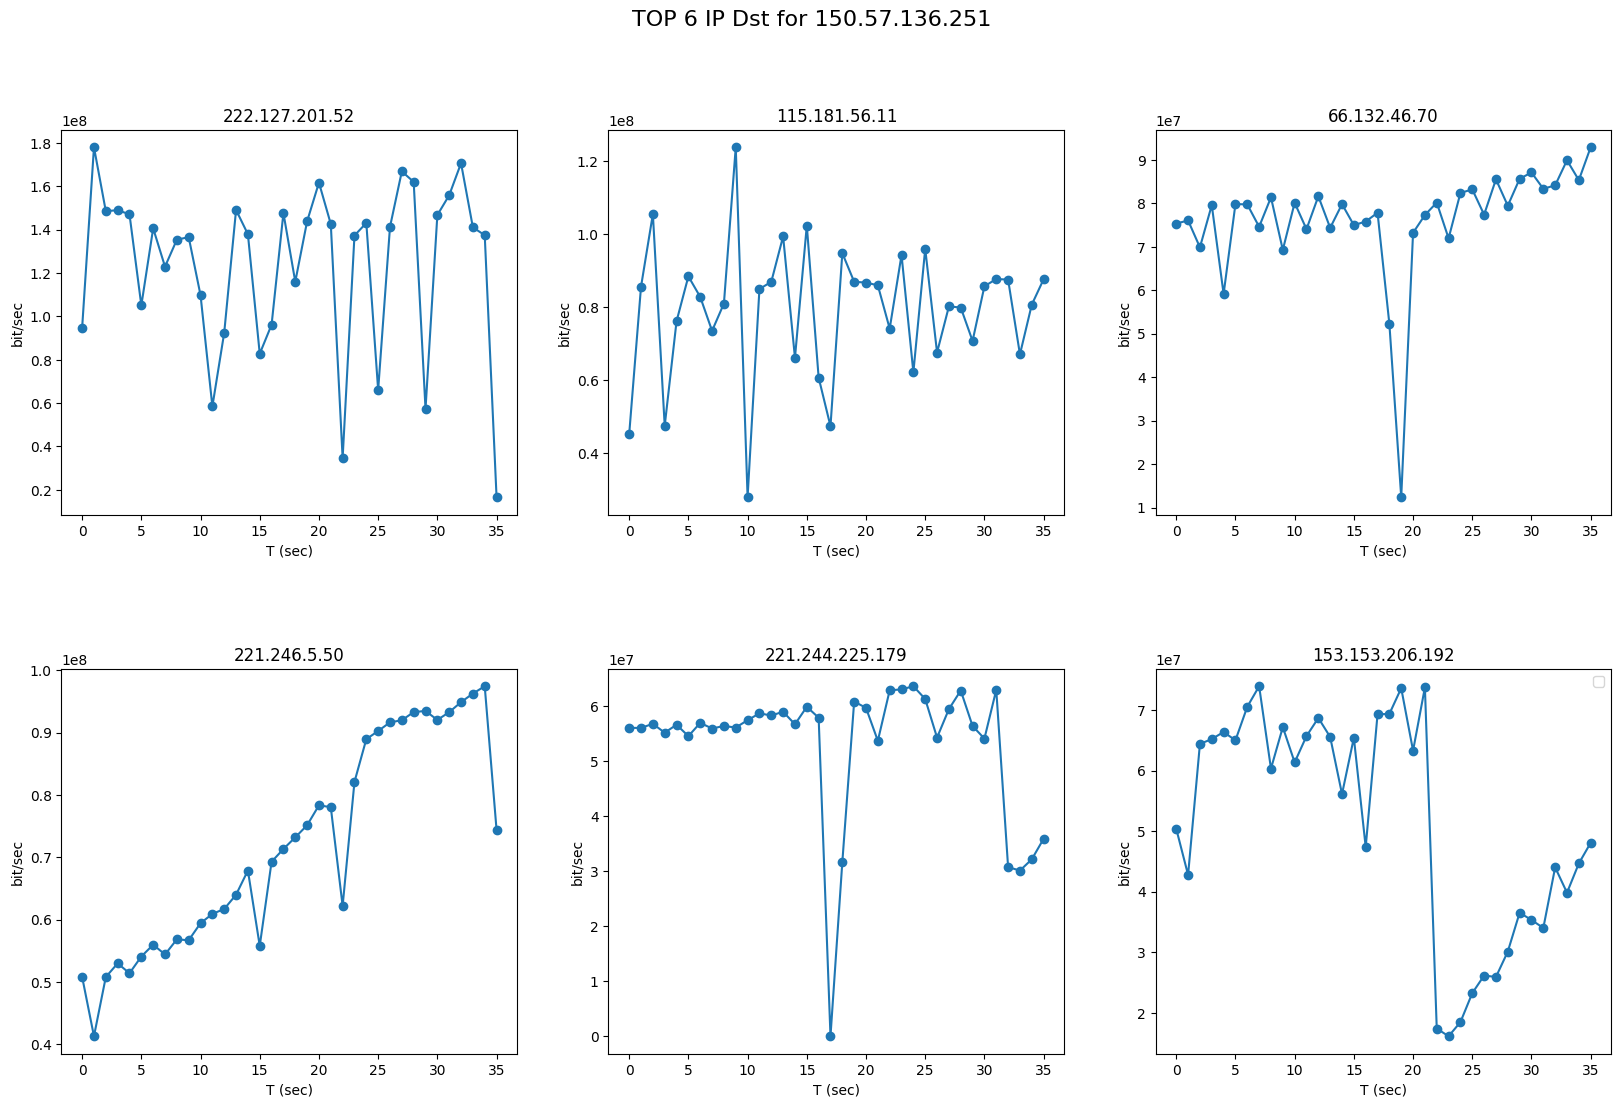

In [175]:
fig, axs = plt.subplots(figsize=(20,12), 
                        nrows=2, ncols=rowlength,     
                        gridspec_kw=dict(hspace=0.4)) 
#fig.tight_layout()
targets = zip(data_destination.index, axs.flatten())
for i, (key, ax) in enumerate(targets):
    print(key)
    #ax.plot(data_couple.get_group(key)["length"])
    ax.plot(bitRate(data_6IPs.get_group(key)),marker = "o")
    ax.set_title(key)
    ax.set_xlabel("T (sec)")
    ax.set_ylabel("bit/sec")
    #ax.set_yscale('log')
ax.legend()
fig.suptitle('TOP 6 IP Dst for 150.57.136.251', fontsize=16)
#plt.savefig("TOP 6 IP Dst for MyIP")
plt.show()

#If now the step in bit rate is 0.1 second, the label of the x axes remains in seconds?

#### 4. Top 5 Destination IP (received bytes) and Top 5 Source IP (sent bytes)


In [43]:
data_top5dest = dataFrame.groupby(["IP_DST"])[['length']].agg('sum').sort_values(by=['length'], ascending=False).head(5)
data_top5dest

length
IP_DST                  
222.127.201.52  56008928
115.181.56.11   36184278
66.132.46.70    34728784
221.246.5.50    32522020
221.5.73.197    32291317

In [77]:
bar_dest = px.bar(data_top5dest, y=data_top5dest.index[:], x = data_top5dest['length'][:]/1e3,
                    title='Top 5 destinations',
                    opacity=0.8,
                    color_discrete_sequence=['#e5b769'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)
bar_dest.update_layout(
    yaxis_title_text ='Destinations',
    xaxis_title_text ='Received Bytes')# gap between bars of adjacent location coordinates
bar_dest.update_yaxes(tickfont_family="Arial Black")
bar_dest.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)



In [46]:
data_top5source = data_couple.sort_values(by=['length'], ascending=False).head(5)

In [58]:
bar_source = px.bar(data_top5source, y=data_top5source.index[:], x = data_top5source['length'][:]/1e3,
                    title='Top 5 sources',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)
bar_source.update_layout(
    yaxis_title_text ='Sources',
    xaxis_title_text ='Bytes Sent')
bar_source.update_yaxes(tickfont_family="Arial Black")
bar_source.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

#### 5. Evaluate bitRate considering all the trace with 3 different sampling rate

In [193]:
bit_plot = px.line(dataFrame,
              x=[ i*0.1 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.1))))+1)],
              y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.1))),
              template='plotly_white',
              title='Total bit rate',
              markers=True)
bit_plot.update_legends
bit_plot.add_scatter(x=[ i*0.4 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.4))))+1)], 
                y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.4))))
bit_plot.add_scatter(x=[ i*0.8 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.8))))+1)], 
                y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.8))))
bit_plot.update_layout(
    yaxis_title_text ='Mbps',
    xaxis_title_text ='Time(s)')

#### 6. GeoLocal Referenciation of the 5 sessions with the highest amount of traffic generated

In [111]:
from ip2geotools.databases.noncommercial import DbIpCity
import folium

In [112]:
def geo_infos(ip_src_list, ip_dst_list):

  src_geo_info = []
  dst_geo_info = []
  i = 0

  for j in range(len(ip_src_list)):
    try:
      src_response = DbIpCity.get(ip_src_list[j], api_key='free')
      dst_response = DbIpCity.get(ip_dst_list[j], api_key='free')
    except:
      continue
    if src_response.latitude == None or dst_response.latitude == None: 
      continue
    i +=1
    src_geo_info.append([src_response.latitude, src_response.longitude, src_response.region])
    dst_geo_info.append([dst_response.latitude, dst_response.longitude, dst_response.region])
    if i == 10: break

  return src_geo_info, dst_geo_info


#### 7. 10 Protocol mostly used

In [161]:
grouped_flows = dataFrame.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
print(grouped_flows)

              IP_SRC           IP_DST  Protocol  src_port  dst_port  tot_len
0       1.33.128.154  203.122.128.169        17       634       123       76
1          10.0.0.31   202.239.228.38        17     57970        53       65
2       10.1.200.200   202.239.228.38        17     58089        53       68
3           10.1.6.2   202.239.228.38         1        -1        -1      224
4        10.10.230.1   202.239.228.38        17     42070        53       57
...              ...              ...       ...       ...       ...      ...
31437  96.226.38.235    131.137.9.254        17        53     63533      141
31438  96.226.38.235    131.137.9.254        17        53     63677       95
31439  96.226.38.235    131.137.9.254        17        53     64459       95
31440  96.226.38.235    131.137.9.254        17        53     65472      100
31441  96.226.38.235  133.245.253.247        17        53     62569       98

[31442 rows x 6 columns]


In [163]:
grouped_flows.Protocol.value_counts().index #we have only 9 protocols??

Int64Index([6, 1, 17, 50, 4, 47, 89, 97, 103], dtype='int64')

In [165]:
grouped_flows["Protocol"] = grouped_flows["Protocol"].replace({1:"ICMP",6:"TCP",17:"UDP",50:"ESP",4:"IPv4",47:"GRE",89:"OSPFIGP",97:"ETHERIP",103:"PIM"}) 
#like this util we do not found the name of the other protocols
#found them in https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

In [170]:
bar_protocol = px.bar(grouped_flows["Protocol"], y=grouped_flows.Protocol.value_counts().index, x = grouped_flows.Protocol.value_counts().values,
                    title='Top 9 Protocols used',
                    opacity=0.8,
                    color_discrete_sequence=['#2a9d8f'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)

bar_protocol.update_layout(
    yaxis_title_text ='Prtocols',
    xaxis_title_text ='Count')
bar_protocol.update_yaxes(tickfont_family="Arial Black")
bar_protocol.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

### 8. Port Scanner evaluation (10 Ports mostly used)

### 9. InterArrival Time boxplot between TCP and UDP Sessions

### 10. Develope your own analysis (e.g. Topology of the network using networkx or evaluation about a variable such as TTL) 